# HDH Partitioning Experiments

Comprehensive experiments using the **actual HDH class** and simplified bin-packing partitioner.

**Tests:**
1. Overhead factor scaling (1.0 → 2.0)
2. QPU count variation (2-6 QPUs)
3. Cross-model comparison (Circuit, MBQC, QW, QCA)
4. Circuit size scaling

Each generates **separate publication-ready PNG images**.

In [6]:
import sys,os
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))  # adds HDH/

from hdh import HDH
from hdh.converters import from_qasm
from hdh.passes import compute_cut

In [7]:
MQTBENCH_PATH = "/Users/mariagragera/Desktop/HDH/database/Workloads/Circuit/MQTBench/"

def load_mqtbench_circuits(path):
    return [
        os.path.join(path, f)
        for f in sorted(os.listdir(path))
        if f.endswith(".qasm")
    ]


In [8]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from typing import List, Set, Dict, Tuple, Optional
from collections import defaultdict, deque
from qiskit import QuantumCircuit

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Create output directory
OUTPUT_DIR = Path('experiment_outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

print("✓ Imports successful")
print(f"✓ Output directory: {OUTPUT_DIR.absolute()}")

✓ Imports successful
✓ Output directory: /Users/mariagragera/Desktop/HDH/hdh/experiment_outputs


## Synthetic HDH Generators

In [9]:
def generate_random_circuit_hdh(num_qubits: int, depth: int, gate_prob: float = 0.3) -> HDH:
    """Generate random circuit-like HDH"""
    hdh = HDH()
    
    # Add all nodes
    for q in range(num_qubits):
        for t in range(depth + 1):
            hdh.add_node(f"q{q}_t{t}", "q", t)
    
    # Wire hyperedges
    for q in range(num_qubits):
        for t in range(depth):
            hdh.add_hyperedge({f"q{q}_t{t}", f"q{q}_t{t+1}"}, "q", "wire", role="teledata")
    
    # Random 2-qubit gates
    for t in range(depth):
        for q1 in range(num_qubits - 1):
            if np.random.rand() < gate_prob:
                q2 = q1 + 1
                hdh.add_hyperedge({
                    f"q{q1}_t{t}", f"q{q1}_t{t+1}",
                    f"q{q2}_t{t}", f"q{q2}_t{t+1}"
                }, "q", "cnot", role="telegate")
    
    return hdh

def generate_mbqc_hdh(num_qubits: int, depth: int) -> HDH:
    """Generate MBQC-like HDH (dense entanglement)"""
    hdh = HDH()
    
    for q in range(num_qubits):
        for t in range(depth):
            hdh.add_node(f"q{q}_t{t}", "q", t)
    
    for t in range(depth):
        for i in range(num_qubits):
            for j in range(i+1, min(i+3, num_qubits)):
                hdh.add_hyperedge({f"q{i}_t{t}", f"q{j}_t{t}"}, "q", "entangle")
    
    return hdh

def generate_qw_hdh(num_qubits: int, depth: int) -> HDH:
    """Generate QW-like HDH (linear chain)"""
    hdh = HDH()
    
    for q in range(num_qubits):
        for t in range(depth):
            hdh.add_node(f"q{q}_t{t}", "q", t)
    
    for t in range(depth):
        for i in range(num_qubits - 1):
            hdh.add_hyperedge({f"q{i}_t{t}", f"q{i+1}_t{t}"}, "q", "hop")
    
    return hdh

def generate_qca_hdh(num_qubits: int, depth: int) -> HDH:
    """Generate QCA-like HDH (2D lattice)"""
    hdh = HDH()
    
    side = int(np.sqrt(num_qubits))
    actual_qubits = side * side
    
    for q in range(actual_qubits):
        for t in range(depth):
            hdh.add_node(f"q{q}_t{t}", "q", t)
    
    for t in range(depth):
        for i in range(side):
            for j in range(side):
                idx = i * side + j
                if j < side - 1:
                    hdh.add_hyperedge({f"q{idx}_t{t}", f"q{idx+1}_t{t}"}, "q", "lattice_h")
                if i < side - 1:
                    hdh.add_hyperedge({f"q{idx}_t{t}", f"q{idx+side}_t{t}"}, "q", "lattice_v")
    
    return hdh

print("✓ HDH generators ready")

✓ HDH generators ready


## Experiment 1: Overhead Factor Scaling

In [10]:
# Generate test circuit
circuits = load_mqtbench_circuits(MQTBENCH_PATH)

for circuit in circuits:
    hdh = from_qasm(input_type="file", qasm=circuit)
    total_qubits = hdh.get_num_qubits()

    # Run overhead experiment
    num_qpus = 4
    overhead_factors = np.arange(1.0, 2.1, 0.1)
    results = []

    print(f"\nTesting with {num_qpus} QPUs...")
    for overhead in overhead_factors:
        total_capacity = int(np.ceil(total_qubits * overhead))
        cap_per_qpu = int(np.ceil(total_capacity / num_qpus))
        
        partitions, cost = compute_cut(hdh, k=num_qpus, cap=cap_per_qpu)
        
        results.append({
            'overhead': overhead,
            'capacity_per_qpu': cap_per_qpu,
            'cut_cost': cost
        })
        print(f"  Overhead {overhead:.1f}: cap={cap_per_qpu}, cuts={cost}")

    df_overhead = pd.DataFrame(results)
    df_overhead.to_csv(OUTPUT_DIR / 'overhead_results.csv', index=False)




Testing with 4 QPUs...
  Overhead 1.0: cap=3, cuts=43
  Overhead 1.1: cap=3, cuts=43
  Overhead 1.2: cap=4, cuts=38
  Overhead 1.3: cap=4, cuts=38
  Overhead 1.4: cap=4, cuts=38
  Overhead 1.5: cap=4, cuts=38
  Overhead 1.6: cap=5, cuts=30
  Overhead 1.7: cap=5, cuts=30
  Overhead 1.8: cap=5, cuts=30
  Overhead 1.9: cap=5, cuts=30
  Overhead 2.0: cap=6, cuts=28

Testing with 4 QPUs...


KeyboardInterrupt: 

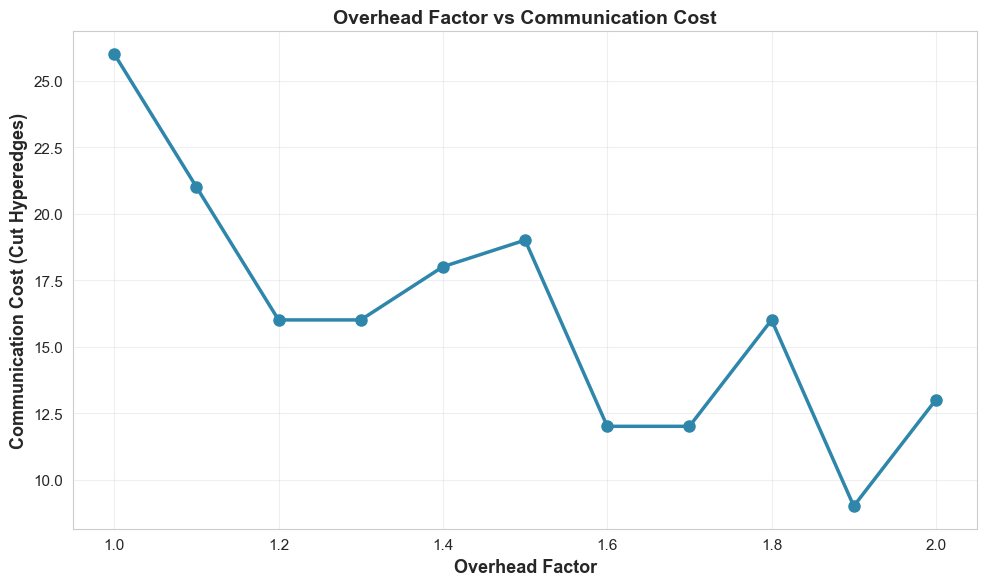

✓ Saved: experiment_outputs/fig1_overhead_scaling.png


In [ ]:
# Plot overhead scaling
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_overhead['overhead'], df_overhead['cut_cost'], 
         'o-', linewidth=2.5, markersize=8, color='#2E86AB')
ax1.set_xlabel('Overhead Factor', fontsize=13, fontweight='bold')
ax1.set_ylabel('Communication Cost (Cut Hyperedges)', fontsize=13, fontweight='bold')
ax1.set_title('Overhead Factor vs Communication Cost', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0.95, 2.05)

# ax2.plot(df_overhead['overhead'], df_overhead['capacity_per_qpu'], 
#          's-', linewidth=2.5, markersize=8, color='#A23B72')
# ax2.set_xlabel('Overhead Factor', fontsize=13, fontweight='bold')
# ax2.set_ylabel('Capacity per QPU (qubits)', fontsize=13, fontweight='bold')
# ax2.set_title('Capacity Scaling', fontsize=14, fontweight='bold')
# ax2.grid(True, alpha=0.3)
# ax2.set_xlim(0.95, 2.05)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig1_overhead_scaling.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'fig1_overhead_scaling.png'}")

## Experiment 2: QPU Count Scaling

In [ ]:
# Run QPU count experiment
overhead = 1.2
qpu_counts = [2, 3, 4, 5, 6]
results_qpu = []

print(f"Testing with overhead={overhead}...")
for num_qpus in qpu_counts:
    total_capacity = int(np.ceil(total_qubits * overhead))
    cap_per_qpu = int(np.ceil(total_capacity / num_qpus))
    
    partitions, cost = compute_cut(hdh, k=num_qpus, cap=cap_per_qpu)
    
    results_qpu.append({
        'num_qpus': num_qpus,
        'capacity_per_qpu': cap_per_qpu,
        'cut_cost': cost
    })
    print(f"  QPUs={num_qpus}: cap={cap_per_qpu}, cuts={cost}")

df_qpu = pd.DataFrame(results_qpu)
df_qpu.to_csv(OUTPUT_DIR / 'qpu_scaling_results.csv', index=False)
print(f"\n✓ Saved: {OUTPUT_DIR / 'qpu_scaling_results.csv'}")

Testing with overhead=1.2...
  QPUs=2: cap=30, cuts=4
  QPUs=3: cap=20, cuts=18
  QPUs=4: cap=15, cuts=21
  QPUs=5: cap=12, cuts=27
  QPUs=6: cap=10, cuts=31

✓ Saved: experiment_outputs/qpu_scaling_results.csv


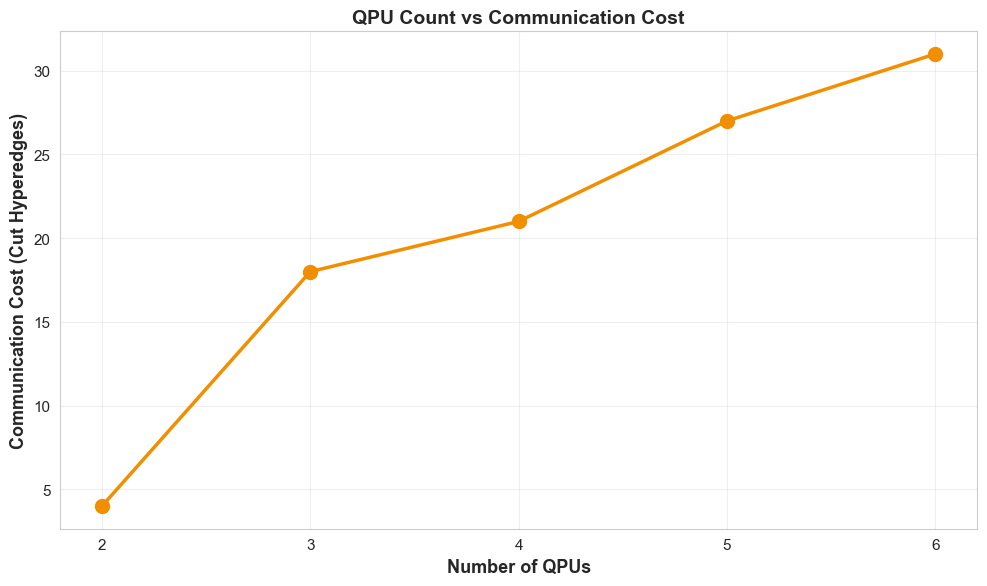

✓ Saved: experiment_outputs/fig2_qpu_scaling.png


In [ ]:
# Plot QPU count scaling
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_qpu['num_qpus'], df_qpu['cut_cost'], 
        'o-', linewidth=2.5, markersize=10, color='#F18F01')
ax.set_xlabel('Number of QPUs', fontsize=13, fontweight='bold')
ax.set_ylabel('Communication Cost (Cut Hyperedges)', fontsize=13, fontweight='bold')
ax.set_title('QPU Count vs Communication Cost', fontsize=14, fontweight='bold')
ax.set_xticks(qpu_counts)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig2_qpu_scaling.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'fig2_qpu_scaling.png'}")

## Experiment 3: Cross-Model Comparison

In [ ]:
def depth_from_size(size, alpha=4):
    return int(np.ceil(alpha * np.log2(size)))


# Run cross-model experiments
models = {
    'Circuit': generate_random_circuit_hdh,
    'MBQC': generate_mbqc_hdh,
    'QW': generate_qw_hdh,
    'QCA': generate_qca_hdh
}

sizes = [16, 32, 64, 128]
num_trials = 5
num_qpus = 4
overhead = 1.2

results_models = []

for model_name, generator in models.items():
    print(f"\nTesting {model_name} model:")
    
    for size in sizes:
        depth = depth_from_size(size)
        
        for trial in range(num_trials):
            
            if model_name == 'Circuit':
                hdh_model = generator(size, depth, 0.3)
            else:
                hdh_model = generator(size, depth)
            
            n_qubits = hdh_model.get_num_qubits()
            total_cap = int(np.ceil(n_qubits * overhead))
            cap_per_qpu = int(np.ceil(total_cap / num_qpus))
            
            partitions, cost = compute_cut(
                hdh_model,
                k=num_qpus,
                cap=cap_per_qpu
            )
            
            results_models.append({
                'model': model_name,
                'num_qubits': n_qubits,
                'depth': depth,
                'trial': trial,
                'cut_cost': cost
            })
            
            print(
                f"  size={size} | depth={depth} | trial={trial}: cuts={cost}"
            )

df_models = pd.DataFrame(results_models)
df_models.to_csv(OUTPUT_DIR / 'cross_model_results.csv', index=False)
print(f"\n✓ Saved: {OUTPUT_DIR / 'cross_model_results.csv'}")



Testing Circuit model:
  size=16 | depth=16 | trial=0: cuts=14
  size=16 | depth=16 | trial=1: cuts=13
  size=16 | depth=16 | trial=2: cuts=11
  size=16 | depth=16 | trial=3: cuts=21
  size=16 | depth=16 | trial=4: cuts=14
  size=32 | depth=20 | trial=0: cuts=15
  size=32 | depth=20 | trial=1: cuts=13
  size=32 | depth=20 | trial=2: cuts=14
  size=32 | depth=20 | trial=3: cuts=11
  size=32 | depth=20 | trial=4: cuts=19
  size=64 | depth=24 | trial=0: cuts=25
  size=64 | depth=24 | trial=1: cuts=25
  size=64 | depth=24 | trial=2: cuts=22
  size=64 | depth=24 | trial=3: cuts=23
  size=64 | depth=24 | trial=4: cuts=27
  size=128 | depth=28 | trial=0: cuts=29
  size=128 | depth=28 | trial=1: cuts=38
  size=128 | depth=28 | trial=2: cuts=34
  size=128 | depth=28 | trial=3: cuts=27
  size=128 | depth=28 | trial=4: cuts=36

Testing MBQC model:
  size=16 | depth=16 | trial=0: cuts=351
  size=16 | depth=16 | trial=1: cuts=351
  size=16 | depth=16 | trial=2: cuts=351
  size=16 | depth=16 | tria

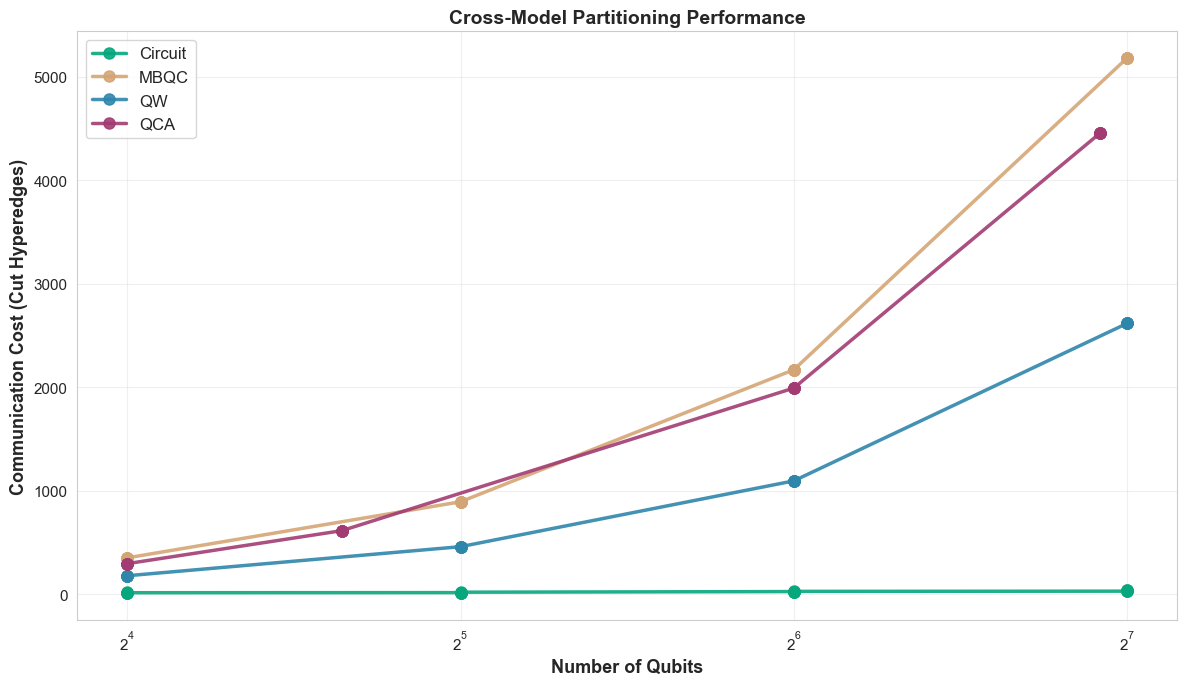

✓ Saved: experiment_outputs/fig3_cross_model.png


In [ ]:
# Plot cross-model comparison
fig, ax = plt.subplots(figsize=(12, 7))

colors = {'Circuit': '#06A77D', 'MBQC': '#D4A574', 'QW': '#2E86AB', 'QCA': '#A23B72'}

for model in models.keys():
    model_data = df_models[df_models['model'] == model]
    ax.plot(model_data['num_qubits'], model_data['cut_cost'], 
           'o-', label=model, linewidth=2.5, markersize=8, 
           color=colors[model], alpha=0.9)

ax.set_xlabel('Number of Qubits', fontsize=13, fontweight='bold')
ax.set_ylabel('Communication Cost (Cut Hyperedges)', fontsize=13, fontweight='bold')
ax.set_title('Cross-Model Partitioning Performance', fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xscale('log', base=2)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig3_cross_model.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'fig3_cross_model.png'}")

## Summary Statistics

In [ ]:
print("="*60)
print("EXPERIMENT SUMMARY")
print("="*60)

print("\n1. Overhead Scaling (50-qubit circuit, 4 QPUs):")
print(f"   Overhead 1.0 → Cost: {df_overhead.iloc[0]['cut_cost']}")
print(f"   Overhead 2.0 → Cost: {df_overhead.iloc[-1]['cut_cost']}")
reduction = df_overhead.iloc[0]['cut_cost'] - df_overhead.iloc[-1]['cut_cost']
print(f"   Reduction: {reduction} cuts ({reduction/df_overhead.iloc[0]['cut_cost']*100:.1f}%)")

print("\n2. QPU Count Impact (overhead=1.2):")
print(f"   2 QPUs → Cost: {df_qpu.iloc[0]['cut_cost']}")
print(f"   6 QPUs → Cost: {df_qpu.iloc[-1]['cut_cost']}")
increase = df_qpu.iloc[-1]['cut_cost'] - df_qpu.iloc[0]['cut_cost']
print(f"   Increase: {increase} cuts")

print("\n3. Cross-Model Performance (64 qubits):")
for model in ['Circuit', 'QW', 'MBQC', 'QCA']:
    model_64 = df_models[(df_models['model']==model) & (df_models['num_qubits']==64)]
    if len(model_64) > 0:
        cost = model_64['cut_cost'].values[0]
        print(f"   {model:8s} → {cost:4d} cuts")

print("\n" + "="*60)
print("All results saved to:", OUTPUT_DIR.absolute())
print("="*60)

EXPERIMENT SUMMARY

1. Overhead Scaling (50-qubit circuit, 4 QPUs):
   Overhead 1.0 → Cost: 26.0
   Overhead 2.0 → Cost: 13.0
   Reduction: 13.0 cuts (50.0%)

2. QPU Count Impact (overhead=1.2):
   2 QPUs → Cost: 4
   6 QPUs → Cost: 31
   Increase: 27 cuts

3. Cross-Model Performance (64 qubits):
   Circuit  →    8 cuts
   QW       →  407 cuts
   MBQC     →  828 cuts
   QCA      →  747 cuts

All results saved to: /Users/mariagragera/Desktop/HDH/hdh/experiment_outputs
